In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Load the data
train = pd.read_csv('train.csv')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
train.shape

(1458644, 11)

In [8]:
# remove outliters
lat = np.array(list(train['pickup_latitude']) + list(train['dropoff_latitude']))
long = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

long_limits = [np.percentile(long, 0.3), np.percentile(long, 99.7)]
lat_limits = [np.percentile(lat, 0.3), np.percentile(lat, 99.7)]
dur_limits = [np.percentile(train['trip_duration'], 0.4), np.percentile(train['trip_duration'], 99.6)]

train = train[(train['pickup_latitude'] >= lat_limits[0]) & (train['pickup_latitude'] <= lat_limits[1])]
train = train[(train['dropoff_latitude'] >= lat_limits[0]) & (train['dropoff_latitude'] <= lat_limits[1])]
train = train[(train['pickup_longitude'] >= long_limits[0]) & (train['pickup_longitude'] <= long_limits[1])]
train = train[(train['dropoff_longitude'] >= long_limits[0]) & (train['dropoff_longitude'] <= long_limits[1])]
train = train[(train['trip_duration'] >= dur_limits[0]) & (train['trip_duration'] <= dur_limits[1])]
train = train.reset_index(drop=True)

allLat = np.array(list(train['pickup_latitude']) + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

In [9]:
train.shape

(1418863, 11)

In [11]:
# convert to sensible units
median_lat = np.percentile(allLat, 50)
median_long = np.percentile(allLong, 50)

lat_multiplier = 111.32
long_multiplier = np.cos(median_lat*(np.pi/180.0)) * 111.32

train['duration [min]'] = train['trip_duration'] / 60.0
train['src lat [km]'] = lat_multiplier * (train['pickup_latitude'] - median_lat)
train['src long [km]'] = long_multiplier * (train['pickup_longitude'] - median_long)
train['dst lat [km]'] = lat_multiplier * (train['dropoff_latitude'] - median_lat)
train['dst long [km]'] = long_multiplier * (train['dropoff_longitude'] - median_long)

all_lat = np.array(list(train['src lat [km]']) + list(train['dst lat [km]']))
all_long = np.array(list(train['src long [km]']) + list(train['dst long [km]']))

Text(0.5, 0, 'longitude [km]')

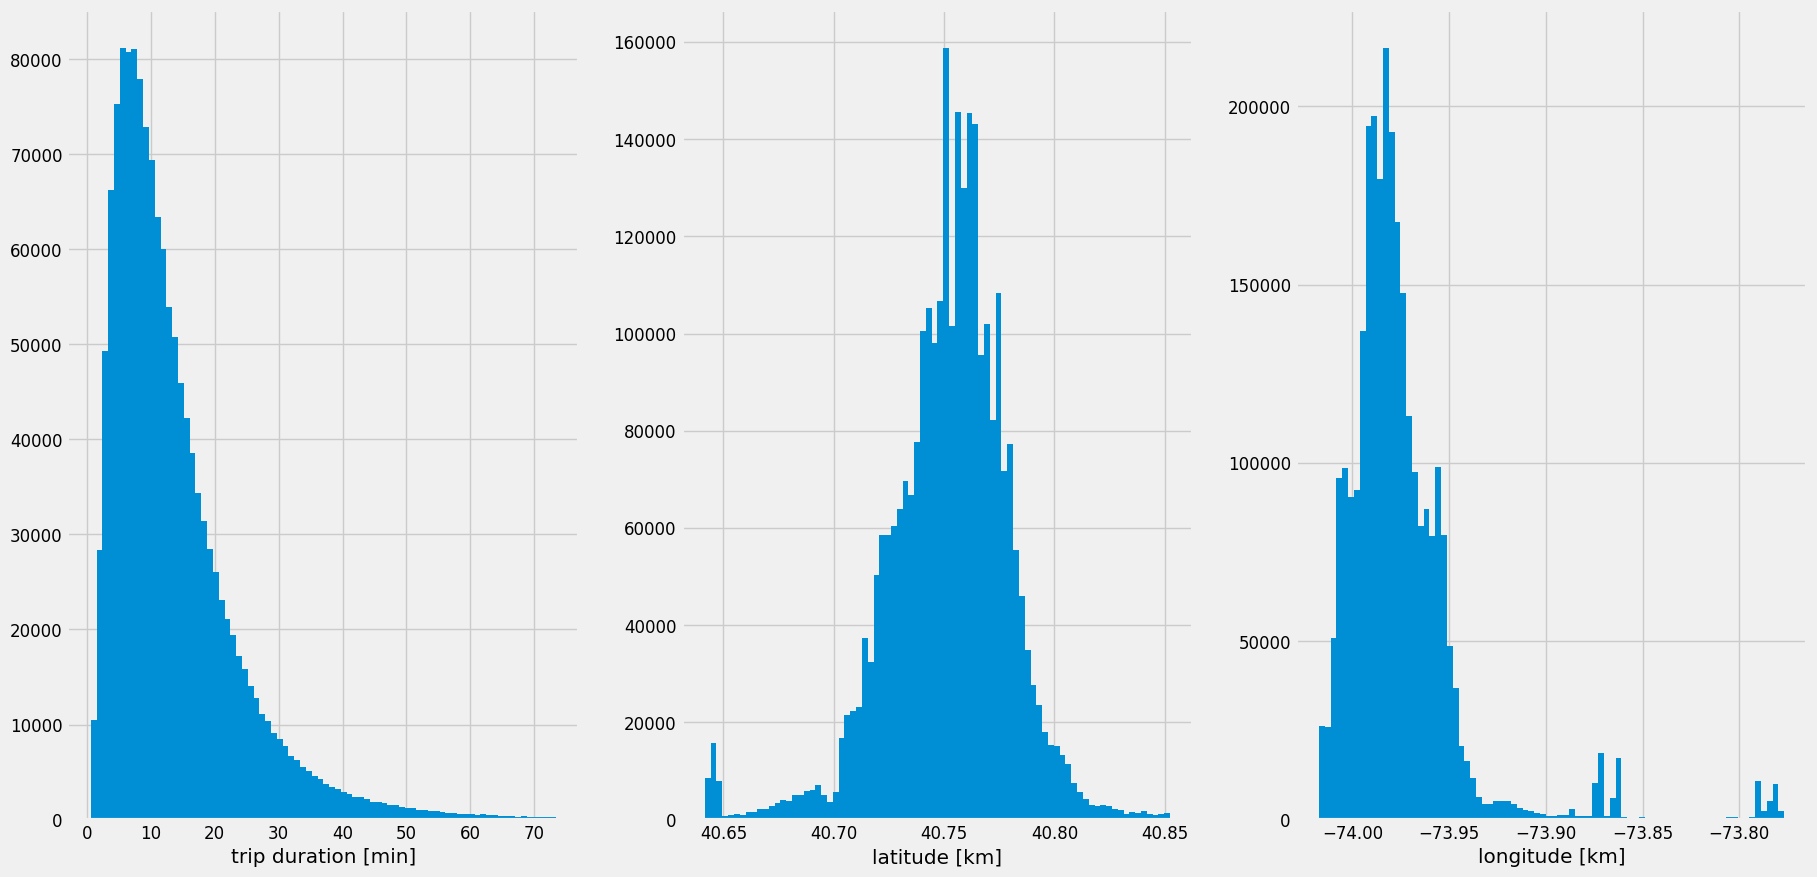

In [14]:
# Plot the data
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].hist(train['duration [min]'], 80)
ax[0].set_xlabel('trip duration [min]')
ax[1].hist(allLat, 80)
ax[1].set_xlabel('latitude [km]')
ax[2].hist(allLong, 80)
ax[2].set_xlabel('longitude [km]')